In [1]:
import warnings
# 忽视警告
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [2]:
def processing_data(data_path, height=224, width=224, batch_size=64,
                    test_split=0.1):
    """
    数据处理部分
    :param data_path: 数据路径
    :param height:高度
    :param width: 宽度
    :param batch_size: 每次读取图片的数量
    :param test_split: 测试集划分比例
    :return: 
    """
    transforms = T.Compose([
        T.Resize((height, width)),
        T.RandomHorizontalFlip(0.1),  # 进行随机水平翻转
        T.RandomVerticalFlip(0.1),  # 进行随机竖直翻转
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])

    dataset = ImageFolder(data_path, transform=transforms)
    # 划分数据集
    train_size = int((1-test_split)*len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # 创建一个 DataLoader 对象
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    valid_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

    return train_data_loader, valid_data_loader

In [3]:
from model import Backbone
class ArcfaceNet(nn.Module):
    def __init__(self, classes=10):
        super(ArcfaceNet, self).__init__()
        self.Arcnet = Backbone(num_layers=50,drop_ratio=0.6,mode='ir_se')
        self.Arcnet.load_state_dict(torch.load('model_ir_se50.pth'))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.Arcnet(x)
        out = self.fc(x)
        return out

In [4]:
torch.cuda.is_available()

True

In [5]:
data_path = './dataset'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_data_loader, valid_data_loader = processing_data(data_path=data_path, height=112, width=112, batch_size=512)

epochs = 200
model = ArcfaceNet(classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=5e-4)  # 优化器
print('加载完成...')

加载完成...


In [6]:
for data in train_data_loader:
    print(data)
    break
    

[tensor([[[[0.4549, 0.3804, 0.2745,  ..., 0.1843, 0.1647, 0.1529],
          [0.4431, 0.4667, 0.3451,  ..., 0.1922, 0.1765, 0.1686],
          [0.3882, 0.5098, 0.3882,  ..., 0.2000, 0.1843, 0.1804],
          ...,
          [0.2157, 0.2039, 0.2196,  ..., 0.1804, 0.1686, 0.1608],
          [0.2314, 0.2000, 0.2157,  ..., 0.2078, 0.1961, 0.1804],
          [0.2471, 0.1961, 0.2039,  ..., 0.1922, 0.1882, 0.1647]],

         [[0.5490, 0.4745, 0.3686,  ..., 0.2863, 0.2667, 0.2549],
          [0.5373, 0.5608, 0.4392,  ..., 0.2941, 0.2784, 0.2706],
          [0.4824, 0.6039, 0.4824,  ..., 0.3020, 0.2863, 0.2824],
          ...,
          [0.1569, 0.1412, 0.1412,  ..., 0.1333, 0.1255, 0.1255],
          [0.1765, 0.1412, 0.1373,  ..., 0.1765, 0.1725, 0.1647],
          [0.1922, 0.1333, 0.1333,  ..., 0.1725, 0.1725, 0.1569]],

         [[0.6510, 0.5765, 0.4706,  ..., 0.3922, 0.3725, 0.3608],
          [0.6392, 0.6627, 0.5412,  ..., 0.4000, 0.3843, 0.3765],
          [0.5843, 0.7059, 0.5843,  ..., 

In [7]:
# 学习率下降的方式，acc三次不下降就下降学习率继续训练，衰减学习率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 'max', 
                                                 factor=0.5,
                                                 patience=2)
# 损失函数
criterion = nn.CrossEntropyLoss()  

In [8]:
best_loss = 1e9
best_model_weights = copy.deepcopy(model.state_dict())
loss_list = []  # 存储损失函数值
for epoch in range(epochs):
    model.train()

    for batch_idx, (x, y) in tqdm(enumerate(train_data_loader, 1)):
        x = x.to(device)
        y = y.to(device)
        pred_y = model(x)


        loss = criterion(pred_y, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_model_weights = copy.deepcopy(model.state_dict())
            best_loss = loss
            
        loss_list.append(loss)

    print('step:' + str(epoch + 1) + '/' + str(epochs) + ' || Total Loss: %.4f' % (loss))
torch.save(model.state_dict(), './results/temp.pth')
print('Finish Training.')

0it [00:00, ?it/s]

step:1/200 || Total Loss: 2.1555


0it [00:00, ?it/s]

step:2/200 || Total Loss: 2.0231


0it [00:00, ?it/s]

step:3/200 || Total Loss: 1.8893


0it [00:00, ?it/s]

step:4/200 || Total Loss: 1.7853


0it [00:00, ?it/s]

step:5/200 || Total Loss: 1.7430


0it [00:00, ?it/s]

step:6/200 || Total Loss: 1.6441


0it [00:00, ?it/s]

step:7/200 || Total Loss: 1.5623


0it [00:00, ?it/s]

step:8/200 || Total Loss: 1.4424


0it [00:00, ?it/s]

step:9/200 || Total Loss: 1.4431


0it [00:00, ?it/s]

step:10/200 || Total Loss: 1.3154


0it [00:00, ?it/s]

step:11/200 || Total Loss: 1.2815


0it [00:00, ?it/s]

step:12/200 || Total Loss: 1.1753


0it [00:00, ?it/s]

step:13/200 || Total Loss: 1.1160


0it [00:00, ?it/s]

step:14/200 || Total Loss: 1.0854


0it [00:00, ?it/s]

step:15/200 || Total Loss: 1.0025


0it [00:00, ?it/s]

step:16/200 || Total Loss: 1.0159


0it [00:00, ?it/s]

step:17/200 || Total Loss: 0.9620


0it [00:00, ?it/s]

step:18/200 || Total Loss: 0.8479


0it [00:00, ?it/s]

step:19/200 || Total Loss: 0.9127


0it [00:00, ?it/s]

step:20/200 || Total Loss: 0.7933


0it [00:00, ?it/s]

step:21/200 || Total Loss: 0.8011


0it [00:00, ?it/s]

step:22/200 || Total Loss: 0.7348


0it [00:00, ?it/s]

step:23/200 || Total Loss: 0.7249


0it [00:00, ?it/s]

step:24/200 || Total Loss: 0.7028


0it [00:00, ?it/s]

step:25/200 || Total Loss: 0.6636


0it [00:00, ?it/s]

step:26/200 || Total Loss: 0.5698


0it [00:00, ?it/s]

step:27/200 || Total Loss: 0.5113


0it [00:00, ?it/s]

step:28/200 || Total Loss: 0.5487


0it [00:00, ?it/s]

step:29/200 || Total Loss: 0.5354


0it [00:00, ?it/s]

step:30/200 || Total Loss: 0.5122


0it [00:00, ?it/s]

step:31/200 || Total Loss: 0.4127


0it [00:00, ?it/s]

step:32/200 || Total Loss: 0.5351


0it [00:00, ?it/s]

step:33/200 || Total Loss: 0.4365


0it [00:00, ?it/s]

step:34/200 || Total Loss: 0.4406


0it [00:00, ?it/s]

step:35/200 || Total Loss: 0.4316


0it [00:00, ?it/s]

step:36/200 || Total Loss: 0.3570


0it [00:00, ?it/s]

step:37/200 || Total Loss: 0.4617


0it [00:00, ?it/s]

step:38/200 || Total Loss: 0.3273


0it [00:00, ?it/s]

step:39/200 || Total Loss: 0.3367


0it [00:00, ?it/s]

step:40/200 || Total Loss: 0.3185


0it [00:00, ?it/s]

step:41/200 || Total Loss: 0.3209


0it [00:00, ?it/s]

step:42/200 || Total Loss: 0.3189


0it [00:00, ?it/s]

step:43/200 || Total Loss: 0.2860


0it [00:00, ?it/s]

step:44/200 || Total Loss: 0.4373


0it [00:00, ?it/s]

step:45/200 || Total Loss: 0.3205


0it [00:00, ?it/s]

step:46/200 || Total Loss: 0.2696


0it [00:00, ?it/s]

step:47/200 || Total Loss: 0.3098


0it [00:00, ?it/s]

step:48/200 || Total Loss: 0.2398


0it [00:00, ?it/s]

step:49/200 || Total Loss: 0.2813


0it [00:00, ?it/s]

step:50/200 || Total Loss: 0.2165


0it [00:00, ?it/s]

step:51/200 || Total Loss: 0.2345


0it [00:00, ?it/s]

step:52/200 || Total Loss: 0.2641


0it [00:00, ?it/s]

step:53/200 || Total Loss: 0.2824


0it [00:00, ?it/s]

step:54/200 || Total Loss: 0.2456


0it [00:00, ?it/s]

step:55/200 || Total Loss: 0.2075


0it [00:00, ?it/s]

step:56/200 || Total Loss: 0.1906


0it [00:00, ?it/s]

step:57/200 || Total Loss: 0.1792


0it [00:00, ?it/s]

step:58/200 || Total Loss: 0.2226


0it [00:00, ?it/s]

step:59/200 || Total Loss: 0.1880


0it [00:00, ?it/s]

step:60/200 || Total Loss: 0.1537


0it [00:00, ?it/s]

step:61/200 || Total Loss: 0.1450


0it [00:00, ?it/s]

step:62/200 || Total Loss: 0.1374


0it [00:00, ?it/s]

step:63/200 || Total Loss: 0.1792


0it [00:00, ?it/s]

step:64/200 || Total Loss: 0.1244


0it [00:00, ?it/s]

step:65/200 || Total Loss: 0.1767


0it [00:00, ?it/s]

step:66/200 || Total Loss: 0.1334


0it [00:00, ?it/s]

step:67/200 || Total Loss: 0.1278


0it [00:00, ?it/s]

step:68/200 || Total Loss: 0.1650


0it [00:00, ?it/s]

step:69/200 || Total Loss: 0.1746


0it [00:00, ?it/s]

step:70/200 || Total Loss: 0.1651


0it [00:00, ?it/s]

step:71/200 || Total Loss: 0.1633


0it [00:00, ?it/s]

step:72/200 || Total Loss: 0.2511


0it [00:00, ?it/s]

step:73/200 || Total Loss: 0.1933


0it [00:00, ?it/s]

step:74/200 || Total Loss: 0.1269


0it [00:00, ?it/s]

step:75/200 || Total Loss: 0.1376


0it [00:00, ?it/s]

step:76/200 || Total Loss: 0.1629


0it [00:00, ?it/s]

step:77/200 || Total Loss: 0.1091


0it [00:00, ?it/s]

step:78/200 || Total Loss: 0.1034


0it [00:00, ?it/s]

step:79/200 || Total Loss: 0.1221


0it [00:00, ?it/s]

step:80/200 || Total Loss: 0.1514


0it [00:00, ?it/s]

step:81/200 || Total Loss: 0.1893


0it [00:00, ?it/s]

step:82/200 || Total Loss: 0.1947


0it [00:00, ?it/s]

step:83/200 || Total Loss: 0.2187


0it [00:00, ?it/s]

step:84/200 || Total Loss: 0.2097


0it [00:00, ?it/s]

step:85/200 || Total Loss: 0.1945


0it [00:00, ?it/s]

step:86/200 || Total Loss: 0.1969


0it [00:00, ?it/s]

step:87/200 || Total Loss: 0.1248


0it [00:00, ?it/s]

step:88/200 || Total Loss: 0.1221


0it [00:00, ?it/s]

step:89/200 || Total Loss: 0.1129


0it [00:00, ?it/s]

step:90/200 || Total Loss: 0.1425


0it [00:00, ?it/s]

step:91/200 || Total Loss: 0.1121


0it [00:00, ?it/s]

step:92/200 || Total Loss: 0.0885


0it [00:00, ?it/s]

step:93/200 || Total Loss: 0.0822


0it [00:00, ?it/s]

step:94/200 || Total Loss: 0.1207


0it [00:00, ?it/s]

step:95/200 || Total Loss: 0.0958


0it [00:00, ?it/s]

step:96/200 || Total Loss: 0.0983


0it [00:00, ?it/s]

step:97/200 || Total Loss: 0.1162


0it [00:00, ?it/s]

step:98/200 || Total Loss: 0.1482


0it [00:00, ?it/s]

step:99/200 || Total Loss: 0.0971


0it [00:00, ?it/s]

step:100/200 || Total Loss: 0.1414


0it [00:00, ?it/s]

step:101/200 || Total Loss: 0.1151


0it [00:00, ?it/s]

step:102/200 || Total Loss: 0.0882


0it [00:00, ?it/s]

step:103/200 || Total Loss: 0.0830


0it [00:00, ?it/s]

step:104/200 || Total Loss: 0.0859


0it [00:00, ?it/s]

step:105/200 || Total Loss: 0.0766


0it [00:00, ?it/s]

step:106/200 || Total Loss: 0.1266


0it [00:00, ?it/s]

step:107/200 || Total Loss: 0.0830


0it [00:00, ?it/s]

step:108/200 || Total Loss: 0.1352


0it [00:00, ?it/s]

step:109/200 || Total Loss: 0.1029


0it [00:00, ?it/s]

step:110/200 || Total Loss: 0.0853


0it [00:00, ?it/s]

step:111/200 || Total Loss: 0.0809


0it [00:00, ?it/s]

step:112/200 || Total Loss: 0.1143


0it [00:00, ?it/s]

step:113/200 || Total Loss: 0.1643


0it [00:00, ?it/s]

step:114/200 || Total Loss: 0.1465


0it [00:00, ?it/s]

step:115/200 || Total Loss: 0.1178


0it [00:00, ?it/s]

step:116/200 || Total Loss: 0.1772


0it [00:00, ?it/s]

step:117/200 || Total Loss: 0.2004


0it [00:00, ?it/s]

step:118/200 || Total Loss: 0.0674


0it [00:00, ?it/s]

step:119/200 || Total Loss: 0.1680


0it [00:00, ?it/s]

step:120/200 || Total Loss: 0.0988


0it [00:00, ?it/s]

step:121/200 || Total Loss: 0.2105


0it [00:00, ?it/s]

step:122/200 || Total Loss: 0.1971


0it [00:00, ?it/s]

step:123/200 || Total Loss: 0.1643


0it [00:00, ?it/s]

step:124/200 || Total Loss: 0.0858


0it [00:00, ?it/s]

step:125/200 || Total Loss: 0.0910


0it [00:00, ?it/s]

step:126/200 || Total Loss: 0.1039


0it [00:00, ?it/s]

step:127/200 || Total Loss: 0.1012


0it [00:00, ?it/s]

step:128/200 || Total Loss: 0.0973


0it [00:00, ?it/s]

step:129/200 || Total Loss: 0.0690


0it [00:00, ?it/s]

step:130/200 || Total Loss: 0.0970


0it [00:00, ?it/s]

step:131/200 || Total Loss: 0.1264


0it [00:00, ?it/s]

step:132/200 || Total Loss: 0.2666


0it [00:00, ?it/s]

step:133/200 || Total Loss: 0.0557


0it [00:00, ?it/s]

step:134/200 || Total Loss: 0.1623


0it [00:00, ?it/s]

step:135/200 || Total Loss: 0.1534


0it [00:00, ?it/s]

step:136/200 || Total Loss: 0.0645


0it [00:00, ?it/s]

step:137/200 || Total Loss: 0.0506


0it [00:00, ?it/s]

step:138/200 || Total Loss: 0.0718


0it [00:00, ?it/s]

step:139/200 || Total Loss: 0.0579


0it [00:00, ?it/s]

step:140/200 || Total Loss: 0.0847


0it [00:00, ?it/s]

step:141/200 || Total Loss: 0.1447


0it [00:00, ?it/s]

step:142/200 || Total Loss: 0.1139


0it [00:00, ?it/s]

step:143/200 || Total Loss: 0.1300


0it [00:00, ?it/s]

step:144/200 || Total Loss: 0.0962


0it [00:00, ?it/s]

step:145/200 || Total Loss: 0.1933


0it [00:00, ?it/s]

step:146/200 || Total Loss: 0.0615


0it [00:00, ?it/s]

step:147/200 || Total Loss: 0.1623


0it [00:00, ?it/s]

step:148/200 || Total Loss: 0.0565


0it [00:00, ?it/s]

step:149/200 || Total Loss: 0.1512


0it [00:00, ?it/s]

step:150/200 || Total Loss: 0.0687


0it [00:00, ?it/s]

step:151/200 || Total Loss: 0.0760


0it [00:00, ?it/s]

step:152/200 || Total Loss: 0.1010


0it [00:00, ?it/s]

step:153/200 || Total Loss: 0.0464


0it [00:00, ?it/s]

step:154/200 || Total Loss: 0.1066


0it [00:00, ?it/s]

step:155/200 || Total Loss: 0.1196


0it [00:00, ?it/s]

step:156/200 || Total Loss: 0.0828


0it [00:00, ?it/s]

step:157/200 || Total Loss: 0.0590


0it [00:00, ?it/s]

step:158/200 || Total Loss: 0.0469


0it [00:00, ?it/s]

step:159/200 || Total Loss: 0.0744


0it [00:00, ?it/s]

step:160/200 || Total Loss: 0.0486


0it [00:00, ?it/s]

step:161/200 || Total Loss: 0.0423


0it [00:00, ?it/s]

step:162/200 || Total Loss: 0.0673


0it [00:00, ?it/s]

step:163/200 || Total Loss: 0.0473


0it [00:00, ?it/s]

step:164/200 || Total Loss: 0.0432


0it [00:00, ?it/s]

step:165/200 || Total Loss: 0.0379


0it [00:00, ?it/s]

step:166/200 || Total Loss: 0.0378


0it [00:00, ?it/s]

step:167/200 || Total Loss: 0.0459


0it [00:00, ?it/s]

step:168/200 || Total Loss: 0.0344


0it [00:00, ?it/s]

step:169/200 || Total Loss: 0.0502


0it [00:00, ?it/s]

step:170/200 || Total Loss: 0.0439


0it [00:00, ?it/s]

step:171/200 || Total Loss: 0.1039


0it [00:00, ?it/s]

step:172/200 || Total Loss: 0.1034


0it [00:00, ?it/s]

step:173/200 || Total Loss: 0.1135


0it [00:00, ?it/s]

step:174/200 || Total Loss: 0.0449


0it [00:00, ?it/s]

step:175/200 || Total Loss: 0.0849


0it [00:00, ?it/s]

step:176/200 || Total Loss: 0.1423


0it [00:00, ?it/s]

step:177/200 || Total Loss: 0.0603


0it [00:00, ?it/s]

step:178/200 || Total Loss: 0.0773


0it [00:00, ?it/s]

step:179/200 || Total Loss: 0.1443


0it [00:00, ?it/s]

step:180/200 || Total Loss: 0.0857


0it [00:00, ?it/s]

step:181/200 || Total Loss: 0.1648


0it [00:00, ?it/s]

step:182/200 || Total Loss: 0.1225


0it [00:00, ?it/s]

step:183/200 || Total Loss: 0.0723


0it [00:00, ?it/s]

step:184/200 || Total Loss: 0.1319


0it [00:00, ?it/s]

step:185/200 || Total Loss: 0.1122


0it [00:00, ?it/s]

step:186/200 || Total Loss: 0.1011


0it [00:00, ?it/s]

step:187/200 || Total Loss: 0.0554


0it [00:00, ?it/s]

step:188/200 || Total Loss: 0.0841


0it [00:00, ?it/s]

step:189/200 || Total Loss: 0.0716


0it [00:00, ?it/s]

step:190/200 || Total Loss: 0.0413


0it [00:00, ?it/s]

step:191/200 || Total Loss: 0.0340


0it [00:00, ?it/s]

step:192/200 || Total Loss: 0.0903


0it [00:00, ?it/s]

step:193/200 || Total Loss: 0.1110


0it [00:00, ?it/s]

step:194/200 || Total Loss: 0.1056


0it [00:00, ?it/s]

step:195/200 || Total Loss: 0.1390


0it [00:00, ?it/s]

step:196/200 || Total Loss: 0.0457


0it [00:00, ?it/s]

step:197/200 || Total Loss: 0.0666


0it [00:00, ?it/s]

step:198/200 || Total Loss: 0.0828


0it [00:00, ?it/s]

step:199/200 || Total Loss: 0.0561


0it [00:00, ?it/s]

step:200/200 || Total Loss: 0.1221
Finish Training.


In [33]:
train_result = []
for loss in loss_list :
    train_result.append(loss.detach().to('cpu').numpy())

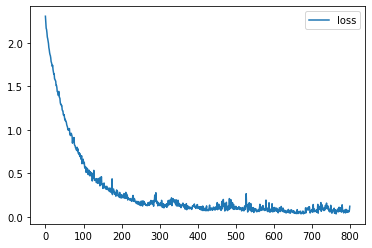

In [32]:
plt.plot(train_result,label = "loss")
plt.legend()
plt.show()

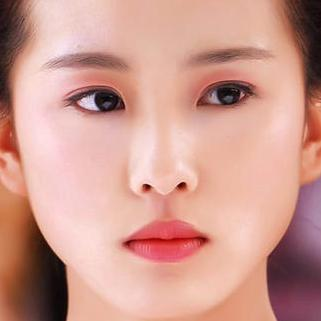

LSS


In [58]:
testpic = Image.open('t2.jpg')
labels = {0:'CL',1:'FBB',2:'HG',3:'HJ',4:'LHR',5:'LSS',6:'LYF',7:'PYY',8:'TY',9:'YM'}
testpic.show()
test_trans = T.Compose([
        T.Resize((112, 112)),
        T.ToTensor(),  # 转化为张量
        T.Normalize([0], [1]),  # 归一化
    ])
testpic = test_trans(testpic)
testpic = testpic.view(1,testpic.shape[0],testpic.shape[1],testpic.shape[2])
model.eval()
with torch.no_grad():
    result = model(testpic.to(device))
    result = labels[np.argmax(result.to('cpu').numpy())]
print(result)
